In [2]:
import networkx as nx
import numpy as np
import copy
import pandas as pd
from scipy.stats import poisson
import random

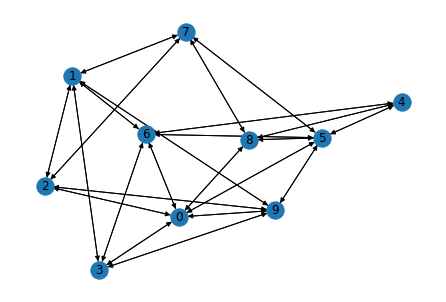

In [6]:
A = np.array([
[0, 0, 4, 5, 0, 2, 1, 0, 7, 2],
[0, 0, 1, 1, 0, 0, 3, 4, 0, 1],
[4, 1, 0, 0, 0, 0, 0, 1, 0, 1],
[5, 1, 0, 0, 0, 0, 2, 0, 0, 1],
[0, 0, 0, 0, 0, 11, 1, 0, 1, 0],
[2, 0, 0, 0, 11, 0, 1, 3, 3, 12],
[1, 3, 0, 2, 1, 1, 0, 0, 0, 0],
[0, 4, 1, 0, 0, 3, 0, 0, 1, 0],
[7, 0, 0, 0, 1, 3, 0, 1, 0, 0],
[2, 1, 1, 1, 0, 12, 0, 0, 0, 0]])
G = nx.from_numpy_matrix(A, create_using=nx.DiGraph)
nx.draw(G,with_labels=True)

In [8]:
# Assume linear charging rate (minutes per percent charge), assume linear consumption of battery
charging = {"0":0, "1":.5, "2":.5, "3":2}
miles_per_percent = 5

# Formulation #1: t_char + t_trav  = W

In [9]:
def layer_graph_simple(graph, increment = 25):
    num_layers = int(100/increment + 1)
    
    # build out duplicate vertices for all layers, labelled
    output_graph = nx.DiGraph()
    nodes = [str(vertex) + "_" + str(layer*increment) for layer in range(num_layers) for vertex in list(graph)]
    output_graph.add_nodes_from(nodes)
    
    # iterate over existing roads in the input graph
    for edge in list(graph.edges):
        src = edge[0]
        dst = edge[1]
        road_weight = graph.get_edge_data(src, dst)['weight']
        road_len = graph.get_edge_data(src, dst)['length']
        
        # for each edge, create all pairwise edges between the src and dest at all appropriate battery levels
        for src_layer in range(num_layers):
            src_battery = src_layer*increment
            src_label = str(src) + "_" + str(src_layer*increment)
            if miles_per_percent*src_battery < road_len: # car won't make it to the next stop
                continue
            for dst_layer in reversed(range(num_layers)):  # go top to bottom. 
                dst_battery = dst_layer*increment
                dst_label = str(dst) + "_" + str(dst_layer*increment)
                if dst_battery > src_battery: # charging occurs at the given stop.
                    charging_weight = (dst_battery-src_battery)*charging[str(src)]
                    output_graph.add_edge(src_label, dst_label, weight = charging_weight + road_weight)
                elif dst_battery < src_battery: # proceed without charging.
                    output_graph.add_edge(src_label, dst_label, weight = road_weight)
                    break
                else: # edge from self not possible.
                    continue
    
    return output_graph
    

# Formulation #2: Google (in - out)

In [1]:
def find_nearest_increment(n, increment=25):
        '''Finds the rounded down defined layer to the battery input (n), inefficiently'''
        curr = 0
        while curr<=n-increment: # runs through levels until hits n (or lower)
            curr+=increment
        
        return curr 

def layer_graph(graph, increment = 25):
    '''Creates a duplicated graph, where each node contains all battery levels both in and out. 
    Directed edges exist from out to in and in to out, the former being roads, and the latter being charging.
    The size of the graph is 3V + VE^2 '''
    num_layers = int(100/increment + 1)
    battery_layers = [increment*l for l in range(num_layers)]
    
    # build out in and out vertices for all layers, labelled [node_percent_in/out]
    output_graph = nx.DiGraph()
    in_nodes = [str(vertex) + "_" + str(layer*increment) + "_in" for layer in range(num_layers) for vertex in list(graph)]
    out_nodes = [str(vertex) + "_" + str(layer*increment) + "_out" for layer in range(num_layers) for vertex in list(graph)]
    nodes = in_nodes + out_nodes
    output_graph.add_nodes_from(nodes)
    output_graph.add_nodes_from([str(node) for node in graph.nodes()]) # add sinks from original
    
    # iterate over existing roads in the input graph (these form links from _out to _in)
    for edge in list(graph.edges):
        src = edge[0]
        dst = edge[1]
        road_weight = graph.get_edge_data(src, dst)['weight']
        road_len = graph.get_edge_data(src, dst)['length']
        
        # create all pairwise edges between the src and dest at all appropriate battery levels
        for src_layer in range(num_layers):
            src_battery = src_layer*increment # number
            src_label = str(src) + "_" + str(src_layer*increment)+ "_out" # source node is _out
            
            # check battery sufficient to travel from _out to _in
            if miles_per_percent*src_battery > road_len:
                # add link to next charging station at current-cost charge
                battery_cost = road_len/5
                battery_layer = find_nearest_increment(src_battery-battery_cost, increment)
                dst_label = str(dst) + "_" + str(battery_layer)+ "_in" # source node is _in
                output_graph.add_edge(src_label, dst_label, weight = road_weight)
        
    # iterate over nodes and connect _in to _out for all positive battery levels, and _out to sinks
    for node in list(graph.nodes):
        for i, src_battery_layer in enumerate(battery_layers):
            src_label = str(node) + "_" + str(src_battery_layer) + "_in"
            for dst_battery_layer in battery_layers[i:]:
                dst_label = str(node) + "_" + str(dst_battery_layer) + "_out"
                charging_time = (dst_battery_layer-src_battery_layer)/charging[str(node)]
                output_graph.add_edge(src_label, dst_label, weight = charging_time) # _in to _out
                output_graph.add_edge(dst_label, str(node), weight = charging_time) # _out to sink
            
    return output_graph

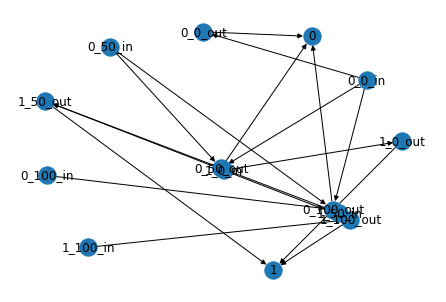

In [54]:
G = nx.Graph()

# add directed and weighted edges
G.add_weighted_edges_from([(0, 1, 75)]) #(1, 2, 140)

# augment graph with road lengths to do range calculations
G.edges[0,1]['length'] = 20
# G.edges[1,2]['length'] = 60

# create layered graph
out = layer_graph(G, 50)
nx.draw(out,with_labels=True)

In [55]:
nx.shortest_path(out,'0_50_in','1_100_out')

['0_50_in', '0_50_out', '1_0_in', '1_100_out']

# TODO

- [x] Add sinks
- [ ] Add variable charging functions
- [ ] Prune pareto non-optimal connections
- [ ] Encode a real network
- [ ] Assess run time
- [ ] How to encode traffic (dynamic)
- [ ] positions

# Model a real positional network

In [19]:
G.get_edge_data

<bound method Graph.get_edge_data of <networkx.classes.graph.Graph object at 0x7ffec594d650>>

In [111]:
loc_df = pd.read_csv("Resources/locations.csv")
loc_df.head(3)

,Loc,Lat,Lng,KPH
0,Albany_NY,42.710356,-73.819109,131
1,Edison_NJ,40.544595,-74.334113,159
2,Dayton_OH,39.858702,-84.277027,133


In [59]:
def get_euclidean_distance(coord1, coord2):
    return np.linalg.norm(coord1 - coord2)

In [105]:
n = len(x)

locs = list(loc_df["Loc"])
x = list(loc_df["Lat"])
y = list(loc_df["Lng"])
distances = np.zeros([n,n])

for i in range(n):
    for j in range(n):
        distances[i,j] = get_euclidean_distance(np.array([x[i],y[i]]), np.array([x[j],y[j]]))

In [121]:
node_list = {row.Loc: {"Lat": row.Lat, "Lng": row.Lng, "KPH": row.KPH} for index, row in loc_df.iterrows()}
pos = {row.Loc: (row.Lng,row.Lat) for index, row in loc_df.iterrows()}

In [122]:
real_G = G = nx.Graph()
real_G.add_nodes_from(node_list)

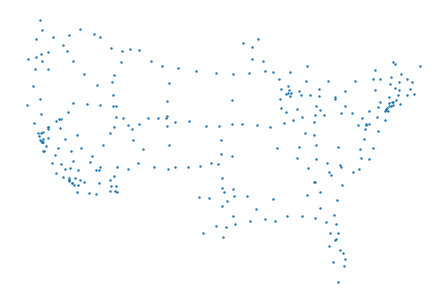

In [124]:
nx.draw(real_G,pos,with_labels=False,node_size = 2)

# Update an existing graph with new demand information

Add current wait times at each charging station along edges from _in to _out charging

In [125]:
time = 0
current_wait_times = {"station": time}

# Simulation Framework

Node attributes: 
- charging_distribution
- wait_time
- physical capacity
- electrical capacity
- current vehicles
- queue_length

Edge attributes:
- mile length
- travel time length
- elevation gain
- elevation loss

In [61]:
class Simulation():
    '''Create a class for a simulation'''
    def __init__(self,simulation_length = 24):
        self.road_G = nx.Graph()
        self.time_interval = 10 
        self.num_batches = 10 
        self.average_demand = 10
        self.simulation_length = simulation_length
    
    def compute_travel_times():
        '''TODO: Will be used to encode uncertainty into the edge weights
        - include rest stops
        - include temporal demand changes'''
        return
    
    def create_road_G(self, mph=55):
        '''Takes in the node and edge csv and creates the self.road_G'''
        node_df = pd.read_csv("data/sample_nodes.csv")
        node_df = node_df.set_index("label")
        node_list = node_df.to_dict('index')
        edges_df = pd.read_csv("data/sample_edges.csv")
        edges_list = edges_df[['src','dst']].to_dict('split')['data']
        edges_attributes = edges_df.to_dict("list")
        
        weight = np.array(edges_attributes['road_length'])
        weight = weight/55*60 + np.array(edges_attributes['elevation_gain'])
        
        G = nx.Graph()
        G.add_edges_from(edges_list, 
                         weight = weight, 
                         length = edges_attributes['road_length'],
                        elevation_gain = edges_attributes['elevation_gain'],
                        current_capacity = 0,
                        capacity = 8)
        self.road_G = G
    
    def randomize_demand():
        return
    
    def time_segment_path():
        return
    
    def simulate():
        return
    
    def run():
        return
    
class Vehicle():
    '''Create a vehicle to store attributes'''
    def __init__():
        self.location = None
        self.start_time = None #between 0 and 24

################# Will be stored in the networkx graph: disregard #################
class Station():
    '''Create a station'''
    def __init__():
        self.lat = None
        self.lng = None
        self.charging_distribution = None
        self.current_vehicle_count = 0
        self.capacity = None

In [60]:
simulation = Simulation()
simulation.create_G()

In [41]:
A = np.array([
[0, 0, 4, 5, 0, 2, 1, 0, 7, 2],
[0, 0, 1, 1, 0, 0, 3, 4, 0, 1],
[4, 1, 0, 0, 0, 0, 0, 1, 0, 1],
[5, 1, 0, 0, 0, 0, 2, 0, 0, 1],
[0, 0, 0, 0, 0, 11, 1, 0, 1, 0],
[2, 0, 0, 0, 11, 0, 1, 3, 3, 12],
[1, 3, 0, 2, 1, 1, 0, 0, 0, 0],
[0, 4, 1, 0, 0, 3, 0, 0, 1, 0],
[7, 0, 0, 0, 1, 3, 0, 1, 0, 0],
[2, 1, 1, 1, 0, 12, 0, 0, 0, 0]])
road_G = nx.from_numpy_matrix(A, create_using=nx.DiGraph)
for src in range(len(A)):
    for dest in range(len(A)):
        if A[src][dest] != 0:
            road_G.edges[src,dest]['length'] = random.randint(20,200)
charging = {"0":1, "1":1, "2":1, "3":1, "4":1, "5":1, "6":1, "7":1, "8":1, "9":1}
miles_per_percent = 5
G = layer_graph(road_G, 50)

In [120]:
def time_segment_path(G, path, time_interval):
    total_path_time = 0
    segment_locations = []
    for i in range(len(path)-1):
        src = path[i]
        dst = path[i+1]
        edge_time = G.get_edge_data(src, dst)['weight']
        
        # assign edge for each time-interval segment within the edge time frame
        curr_path_time = total_path_time
        while curr_path_time + time_interval <= total_path_time + edge_time:
            # if charging, src _in
            if src[-3:]=="_in" and src[:-3]!=dst[:-4]:
                charging_node = src.split("_")[0]
                segment_locations.append(charging_node)
            else:
                src_node = src.split("_")[0]
                dst_node = dst.split("_")[0]
                segment_locations.append((src_node, dst_node))
            curr_path_time += time_interval
            
        # update total path time
        total_path_time += edge_time
    return (segment_locations, total_path_time)

In [121]:
path = nx.shortest_path(G,'2_50_in','4_50_out')
segments, total_time = segment_path(G, path, 10)
segments;

['0',
 '0',
 '0',
 '0',
 '0',
 '5',
 '5',
 '5',
 '5',
 '5',
 ('5', '4'),
 '4',
 '4',
 '4',
 '4',
 '4']

In [ ]:
def add_wait_time(G, station, time, battery_interval):
    '''Mutates the graph G to add "time" to the edges between the station _in to _out'''
    battery_layers = [battery_interval*l for l in range(num_layers)]
    for in_battery_level in battery_layers: # all start levels 0 to 100
        in_label = station + "_"+ in_battery_level + "_in"
        for out_battery_level in range(in_battery_level, 100+battery_interval,battery_interval): # all ends > start
            out_label = station + "_"+ out_battery_level + "_out"
                G[in_label][out_label] += time
    return G

In [ ]:
def add_congestion_time(G, src, dst, time, battery_interval):
    '''Mutates the graph G to add time along edges _out to _in'''
    battery_layers = [battery_interval*l for l in range(num_layers)]
    for in_battery_level in battery_layers: # all start levels 0 to 100
        in_label = station + "_"+ in_battery_level + "_in"
        for edge in G.edges(in_label):
            edge['weight'] += time
    return G

In [ ]:
def single_route_simulation(G, source, destination, num_batches, average_demand):
    '''Runs a simulation of demand caused by vehicles trying to travel from source to destination.
    There will be num_batches of groups leaving at the same time. The size of the group is generated
    by a poisson distribution with average_demand'''
    all_time_segments = []
    for batch_index batch in enumerate(range(num_batches)): # a batch is released every 15 minutes
        demand = np.random(average_demand) # random amount of trucks released at the same time in the batch
        for vehicle_index, vehicle in enumerate(range(demand)):
            starting_battery = random.random.choice([50, 100]) # TODO: parameterize the battery level choices
            starting_label = source + "_" + starting_battery + "_in" # TODO: do we always start at a charging station?
            nx.shortest_path(G,starting_label,destination)
            leading_zero_time_segmentation = [0 for x in range(batch_index)]
            time_segmentation = leading_zero_time_segmentation + time_segment_path(G,path)
            # TODO: path segmentation?
            all_time_segments.append(time_segmentation)
        # TODO post-batch actions
        # assess physical capacities (add weights to charging times)
        # assess congestion
        # assess electrical capacities (add weights to charinging times)
    return all_time_segments

In [2]:
average_demand = 5
num_batches = 30
start_times = np.cumsum(poisson.rvs(1/average_demand, size=num_batches))
start_times

array([0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4])

In [3]:
# approach #1: for each 15 minute interval, number of occurrences is Pois(avg demand per interval)
intervals = np.random.poisson(average_demand,num_batches)
intervals

array([4, 4, 5, 4, 9, 8, 3, 5, 5, 3, 1, 3, 4, 3, 5, 4, 6, 8, 2, 1, 9, 5,
       5, 7, 3, 3, 5, 7, 4, 5])

In [4]:
# approach #2: release at each interarrival time based on demand
intervals = np.random.exponential(1/average_demand,num_batches)
cum_intervals = np.cumsum(intervals)